In [1]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from arch import *

from pytorch_lightning import Trainer

import torch
import dgl

In [2]:
import scienceplots

#plt.style.use(['science','ieee'])

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

# Data

(400, 600, 3)


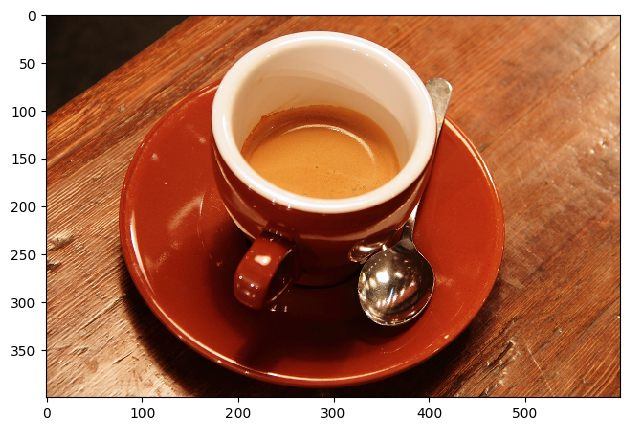

In [4]:
img = data.coffee() / 255.
print(img.shape)
io.imshow(img)

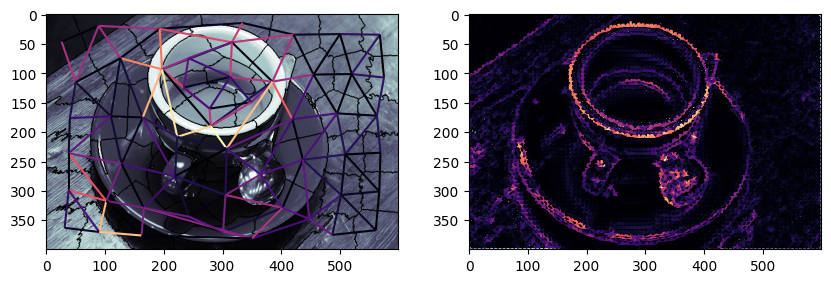

In [5]:
labels_x = segmentation.slic(img, compactness=30, n_segments=50, start_label=1)
gx = graph.rag_mean_color(img, labels_x)
labels_y = segmentation.slic(img, compactness=30, n_segments=5000, start_label=1)
gy = graph.rag_mean_color(img, labels_y)

if img.ndim == 3:
    f, ax = plt.subplots(1,2, figsize=(10,15))
    graph.show_rag(labels_x, gx, img, ax=ax[0])
    graph.show_rag(labels_y, gy, img, ax=ax[1])

In [6]:
labels_copy = labels_y.copy()
gy_copy = gy.copy()
img_copy = img.copy()

In [7]:
def rag_to_numpy(g):
    N = g.number_of_nodes()
    A = np.zeros((N, N))
    for elem in g.adjacency():
        row = elem[0] - 1
        for k, v in elem[1].items():
            col = k-1
            A[row, col] = v['weight']
    return A

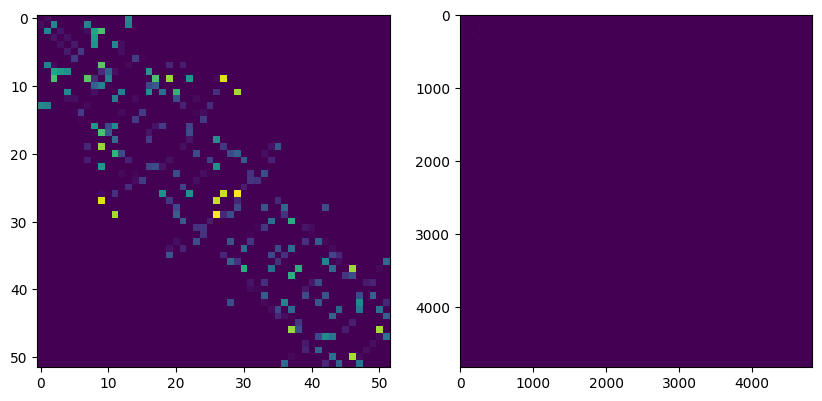

In [8]:
Ax = rag_to_numpy(gx)
Ay = rag_to_numpy(gy)
f, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(Ax)
ax[1].imshow(Ay)

In [9]:
gx.nodes[1]['mean color']

array([0.12321107, 0.0797284 , 0.0471183 ])

In [10]:
X = np.array([gx.nodes[i]['mean color'] for i in gx.nodes])
Y = np.array([gy.nodes[i]['mean color'] for i in gy.nodes])
X.shape, Ax.shape, Y.shape, Ay.shape

((52, 3), (52, 52), (4828, 3), (4828, 4828))

In [11]:
Nx = gx.number_of_nodes()
Ny = gy.number_of_nodes()

In [12]:
gx_nx = dgl.from_networkx(gx.copy()).to(device)
gy_nx = dgl.from_networkx(gy.copy()).to(device)
X = torch.Tensor(X.copy()).to(device)
Y = torch.Tensor(Y.copy()).to(device)
X.shape, Y.shape

(torch.Size([52, 3]), torch.Size([4828, 3]))

In [13]:
norm_data = False
if norm_data:
    X /= (X**2).sum()
    Y /= (Y**2).sum()

# Training the model

In [14]:
lr = 1e-3
wd = 0
n_epochs = 100
n_layers = 2
hid_dim = 512
eval_freq = 20

method = "transpose"
nonlin = nn.ReLU

In [15]:
lr = 1e-2
wd = 0
n_epochs = 200
n_layers = 3
hid_dim = 128
eval_freq = 20

method = "transpose"
nonlin = nn.Tanh

In [16]:
in_dim = X.shape[1]
out_dim = Y.shape[1]

In [17]:
N_train = 0.3
idxs = np.random.permutation(Ny)
train_idx = idxs[:int(Ny*N_train)]
test_idx = idxs[int(Ny*N_train):]

In [18]:
def test(model, X, Y, gx, gy, train_idx, test_idx, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = torch.nn.MSELoss()

    loss_train, loss_test = [np.zeros(n_epochs) for _ in range(2)]

    for i in range(n_epochs):
        y_hat = model(gx, gy, X)
        loss = loss_fn(y_hat[train_idx,:], Y[train_idx,:])

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_train[i] = loss.item()
        loss_test[i] = ((y_hat[test_idx,:] - Y[test_idx,:])**2).mean()

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss Train: {loss_train[i]} - Loss Test: {loss_test[i]}", flush=True)

    return loss_train, loss_test

In [19]:
build_params_gcn = {'norm': 'both'}
build_params_gat = {'num_heads': 8, 'feat_drop': 0.2, 'attn_drop': 0.2}
#build_params_gcnh = {'Sx': torch.tensor(Ax, device=device).float(), 'Sy': torch.tensor(Ay, device=device).float(), 'K': 3}

In [20]:
X.shape

torch.Size([52, 3])

In [21]:
gx.nodes[10]

{'labels': [10],
 'pixel count': 3141,
 'total color': array([3006.75686275, 2790.08235294, 2561.2627451 ]),
 'mean color': array([0.95726102, 0.88827837, 0.81542908]),
 'centroid': (93, 197)}

In [22]:
central_pixels_x = np.zeros((Nx, 2))
for i in range(Nx):
    idxs = np.where(labels_x == i+1)
    central_pixels_x[i,:] = (idxs[0].mean(), idxs[1].mean())

central_pixels_y = np.zeros((Ny, 2))
for i in range(Ny):
    idxs = np.where(labels_y == i+1)
    central_pixels_y[i,:] = (idxs[0].mean(), idxs[1].mean())

In [23]:
C = np.zeros((Ny, Nx))
K = 2
for i in range(Ny):
    dists = ((central_pixels_x - central_pixels_y[i,:])**2).sum(1)
    idxs = np.argsort(dists)
    for k in range(K):
        C[i,idxs[k]] = 1. / K

C = torch.tensor(C, device=device).float()

In [24]:
y_hat_knn = (C @ X).cpu().numpy()

In [25]:
iogcn = IOGCN(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, [], method, build_params_gcn, nonlin=nonlin, C=C).to(device)
loss_train_io, loss_test_io = test(iogcn, X, Y, gx_nx, gy_nx, train_idx, test_idx)

Epoch 1/200 - Loss Train: 0.2317655384540558 - Loss Test: 0.23190534114837646
Epoch 20/200 - Loss Train: 0.04521270468831062 - Loss Test: 0.04371578246355057
Epoch 40/200 - Loss Train: 0.015458405949175358 - Loss Test: 0.020113999024033546
Epoch 60/200 - Loss Train: 0.004941992927342653 - Loss Test: 0.010904023423790932
Epoch 80/200 - Loss Train: 0.0032160934060811996 - Loss Test: 0.010168747045099735
Epoch 100/200 - Loss Train: 0.002577120903879404 - Loss Test: 0.010200544260442257
Epoch 120/200 - Loss Train: 0.0020821078214794397 - Loss Test: 0.010298124514520168
Epoch 140/200 - Loss Train: 0.0016708201728761196 - Loss Test: 0.01062062382698059
Epoch 160/200 - Loss Train: 0.0013302626321092248 - Loss Test: 0.011054294183850288
Epoch 180/200 - Loss Train: 0.0010613090125843883 - Loss Test: 0.011585869826376438
Epoch 200/200 - Loss Train: 0.0008587674237787724 - Loss Test: 0.01218535378575325


In [26]:
iogat = IOGAT(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, [], method, build_params_gat, nonlin=nonlin).to(device)
loss_train_iogat, loss_test_iogat = test(iogat, X, Y, gx_nx, gy_nx, train_idx, test_idx)

Epoch 1/200 - Loss Train: 0.23209485411643982 - Loss Test: 0.2323412299156189
Epoch 20/200 - Loss Train: 1.3766435384750366 - Loss Test: 1.4913663864135742
Epoch 40/200 - Loss Train: 0.5163020491600037 - Loss Test: 0.5144852995872498
Epoch 60/200 - Loss Train: 0.35254979133605957 - Loss Test: 0.3625947833061218
Epoch 80/200 - Loss Train: 0.31327351927757263 - Loss Test: 0.323354572057724
Epoch 100/200 - Loss Train: 0.31678348779678345 - Loss Test: 0.2985924482345581
Epoch 120/200 - Loss Train: 0.2631027102470398 - Loss Test: 0.2629142105579376
Epoch 140/200 - Loss Train: 0.2414027601480484 - Loss Test: 0.2500668168067932
Epoch 160/200 - Loss Train: 0.24178577959537506 - Loss Test: 0.23094281554222107
Epoch 180/200 - Loss Train: 0.23060686886310577 - Loss Test: 0.2302008867263794
Epoch 200/200 - Loss Train: 0.22091026604175568 - Loss Test: 0.20988771319389343


In [27]:
# iogcnh = IOGCNH(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, [], method, build_params_gcnh, nonlin=nonlin).to(device)
# loss_train_ioh, loss_test_ioh = test(iogcnh, X, Y, gx_nx, gy_nx, train_idx, test_idx)

In [30]:
iomlp = IOMLP(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, [], method, build_params=None, nonlin=nonlin).to(device)
loss_train_mlp, loss_test_mlp = test(iomlp, X, Y, gx_nx, gy_nx, train_idx, test_idx)

Epoch 1/200 - Loss Train: 0.2956482768058777 - Loss Test: 0.2966230809688568
Epoch 20/200 - Loss Train: 0.02139369398355484 - Loss Test: 0.06987668573856354
Epoch 40/200 - Loss Train: 0.002534186700358987 - Loss Test: 0.06591898947954178
Epoch 60/200 - Loss Train: 0.0003876970731653273 - Loss Test: 0.06048481911420822
Epoch 80/200 - Loss Train: 0.00012989577953703701 - Loss Test: 0.06054377928376198
Epoch 100/200 - Loss Train: 9.258202771889046e-05 - Loss Test: 0.060647930949926376
Epoch 120/200 - Loss Train: 0.00038837327156215906 - Loss Test: 0.059214379638433456
Epoch 140/200 - Loss Train: 8.936982339946553e-05 - Loss Test: 0.05906098708510399
Epoch 160/200 - Loss Train: 6.202151416800916e-05 - Loss Test: 0.059080470353364944
Epoch 180/200 - Loss Train: 5.372900704969652e-05 - Loss Test: 0.05910923704504967
Epoch 200/200 - Loss Train: 4.7781330067664385e-05 - Loss Test: 0.05924657732248306


In [31]:
for model in [iogcn, iomlp]:
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

663519
663519
663519
663519


In [32]:
y_hat_iogcn = iogcn(gx_nx, gy_nx, X).cpu().detach().numpy()
#y_hat_iogcnh = iogcnh(gx_nx, gy_nx, X).cpu().detach().numpy()
y_hat_iomlp = iomlp(gx_nx, gy_nx, X).cpu().detach().numpy()
y_hat_iogcn.shape

(4828, 3)

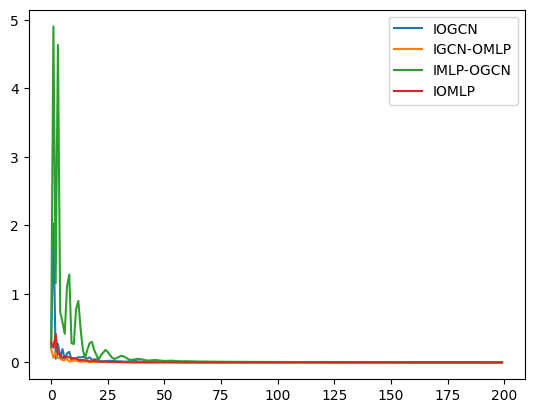

In [33]:
plt.plot(loss_train_io)
plt.plot(loss_train_mlp)
plt.legend(["IOGCN", "IOMLP"])

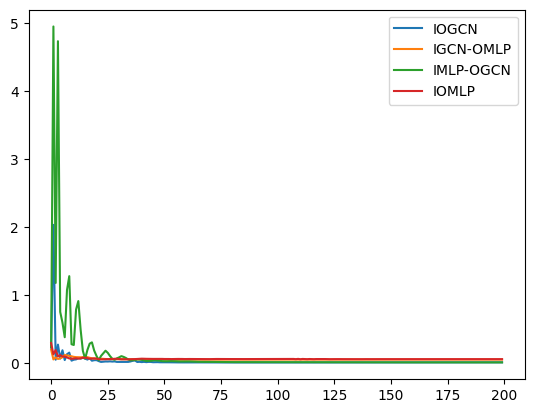

In [34]:
plt.plot(loss_test_io)
plt.plot(loss_test_mlp)
plt.legend(["IOGCN", "IOMLP"])

In [35]:
out_shape = img.shape if img.ndim == 3 else (img.shape[0], img.shape[1], 3)

img_iogcn = np.zeros(out_shape)
#img_iogcnh = np.zeros(out_shape)
img_iomlp = np.zeros(out_shape)
img_knn = np.zeros(out_shape)
img_mean = np.zeros(out_shape)
img_mean_x = np.zeros(out_shape)
img_mean_y = np.zeros(out_shape)

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_iogcn[i,j] = y_hat_iogcn[labels_y[i,j]-1]
        #img_iogcnh[i,j] = y_hat_iogcnh[labels_y[i,j]-1]
        img_iomlp[i,j] = y_hat_iomlp[labels_y[i,j]-1]
        img_knn[i,j] = y_hat_knn[labels_y[i,j]-1]
        img_mean[i,j] = gy.nodes[labels_y[i,j]]['mean color']
        img_mean_x[i,j] = gx.nodes[labels_x[i,j]]['mean color']
        img_mean_y[i,j] = gy.nodes[labels_y[i,j]]['mean color']

In [36]:
mask_train = np.isin(labels_y, train_idx)
mask_test = np.isin(labels_y, test_idx)
mask_test.shape

(400, 600)

In [37]:
input_cnn = torch.tensor(img_mean_x).permute(2,0,1).unsqueeze(0).float().to(device)
out_cnn = torch.tensor(img_mean_y).float().to(device)
input_cnn.shape

torch.Size([1, 3, 400, 600])

In [38]:
# Starting from img_mean_x, apply CNN to perform the interpolation
cnn = nn.Sequential(
    nn.Conv2d(in_dim, hid_dim, 5, padding='same'),
    nn.Conv2d(hid_dim, out_dim, 5, padding='same')
).to(device)

opt_cnn = torch.optim.Adam(cnn.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()

for e in range(n_epochs):
    cnn.train()
    y_hat = cnn(input_cnn).squeeze().permute(1,2,0)

    loss = loss_fn(y_hat[mask_train], out_cnn[mask_train])

    opt_cnn.zero_grad()
    loss.backward()
    opt_cnn.step()

    if (e+1) % eval_freq == 0:
        print(f"Epoch {e+1} - Loss train: {loss.item()}")

img_cnn = cnn(input_cnn).squeeze().permute(1,2,0).detach().cpu().numpy()

Epoch 20 - Loss train: 0.03433665260672569
Epoch 40 - Loss train: 0.04892636090517044
Epoch 60 - Loss train: 0.032421521842479706
Epoch 80 - Loss train: 0.009318576194345951
Epoch 100 - Loss train: 0.008022571913897991
Epoch 120 - Loss train: 0.007840779609978199
Epoch 140 - Loss train: 0.007734287530183792
Epoch 160 - Loss train: 0.007659470662474632
Epoch 180 - Loss train: 0.00759719405323267
Epoch 200 - Loss train: 0.007542451843619347


In [39]:
imgs = {
    'IOGCN': img_iogcn,
    'CNN': img_cnn,
    'KNN': img_knn,
    'IOMLP': img_iomlp,
    'Mean X': img_mean_x,
    'Target/Mean Y': img_mean_y
}

In [40]:
out = segmentation.mark_boundaries(img_iogcn, labels_y, (0, 0, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


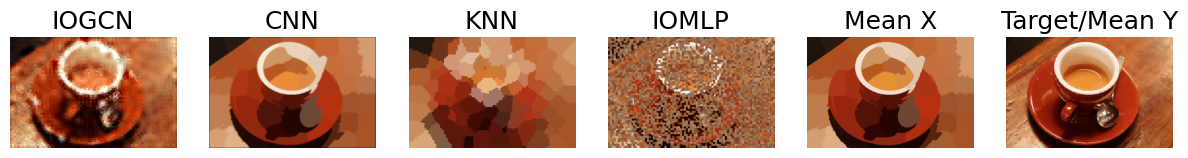

In [41]:
f, ax = plt.subplots(1, len(imgs), figsize=(15,20))

for i, (k, v) in enumerate(imgs.items()):
    ax[i].imshow(v)
    ax[i].set_title(k, fontsize=18)
    ax[i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


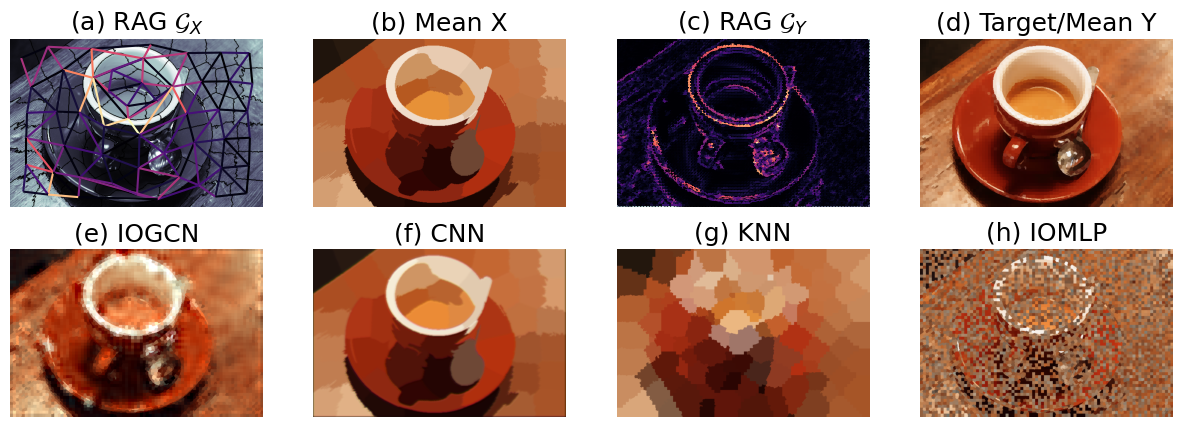

In [42]:
f, ax = plt.subplots(2, 4, figsize=(15,5))

graph.show_rag(labels_x, gx, img, ax=ax[0,0])
ax[0,0].set_title("(a) RAG $\mathcal{G}_X$", fontsize=18)
ax[0,0].axis('off')

ax[0,1].imshow(img_mean_x)
ax[0,1].set_title("(b) Mean X", fontsize=18)
ax[0,1].axis('off')

graph.show_rag(labels_y, gy, img, ax=ax[0,2])
ax[0,2].set_title("(c) RAG $\mathcal{G}_Y$", fontsize=18)
ax[0,2].axis('off')

ax[0,3].imshow(img_mean_y)
ax[0,3].set_title("(d) Target/Mean Y", fontsize=18)
ax[0,3].axis('off')

lets = ['e', 'f', 'g', 'h']

for i, (k, v) in enumerate(imgs.items()):
    if "Mean" in k:
        continue
    ax[1,i].imshow(v)
    ax[1,i].set_title(f"({lets[i]}) {k}", fontsize=18)
    ax[1,i].axis('off')

f.savefig('sample_img.pdf')

In [43]:
((y_hat_iogcn - Y.cpu().detach().numpy())**2).mean(), ((np.zeros(Y.shape) - Y.cpu().detach().numpy())**2).mean()

(0.008806992, 0.23179598297041012)

In [44]:
((img_iogcn - img)**2).mean(), ((img_mean_x - img)**2).mean(), ((img_cnn - img)**2).mean()

(0.011605210129242554, 0.009468911958152384, 0.009725392202443754)

# More exhaustive tests

In [45]:
build_params = {
    'IOGCN': build_params_gcn,
    'IOGAT': build_params_gat,
    #'IOGCNH': build_params_gcnh,
    'IOMLP': None
}

In [46]:
EXPS = [
    {
        "model_name": "IOGCN",
        "method": "linear",
        "legend": "IOGCN-W"
    },
    {
        "model_name": "IOGCN",
        "method": "transpose",
        "legend": "IOGCN-T"
    },
    {
        "model_name": "IOGCN",
        "method": "selection",
        "legend": "IOGCN-S"
    },
    # {
    #     "model_name": "IOGAT",
    #     "method": "linear",
    #     "legend": "IOGAT-L"
    # },
    # {
    #     "model_name": "IOGAT",
    #     "method": "transpose",
    #     "legend": "IOGAT-T"
    # },
    # {
    #     "model_name": "IOGAT",
    #     "method": "selection",
    #     "legend": "IOGAT-C"
    # },
    {
        "model_name": "IOMLP",
        "method": "linear",
        "legend": "IOMLP-W"
    },
    {
        "model_name": "IOMLP",
        "method": "transpose",
        "legend": "IOMLP-T"
    },
    {
        "model_name": "IOMLP",
        "method": "selection",
        "legend": "IOMLP-S"
    }
]

In [47]:
NyNxratios = [1, 10, 100, 1000, 1500, 2000, 2500, 3000]
Nx = 50
assert Nx*max(NyNxratios) < img.shape[0]*img.shape[1], "More segments than pixels in the image"
n_graphs = 10

N_train = 0.6

losses_test = np.zeros((len(NyNxratios), len(EXPS)+1, n_graphs))
err_img = np.zeros((len(NyNxratios), len(EXPS)+3, n_graphs)) # Plus 2 for the mean in x and y

for r, ratio in enumerate(NyNxratios):
    print(f"Starting ratio {ratio} ({r+1}/{len(NyNxratios)}) - ", end="")

    labels_x = segmentation.slic(img, compactness=30, n_segments=Nx, start_label=1)
    gx = graph.rag_mean_color(img, labels_x)
    labels_y = segmentation.slic(img, compactness=30, n_segments=int(Nx*ratio), start_label=1)
    gy = graph.rag_mean_color(img, labels_y)

    # Ax = rag_to_numpy(gx)
    # Ay = rag_to_numpy(gy)
    #build_params['iogcnh'] = {'Sx': torch.tensor(Ax, device=device).float(), 'Sy': torch.tensor(Ay, device=device).float(), 'K': 3}

    X = np.array([gx.nodes[i]['mean color'] for i in gx.nodes])
    Y = np.array([gy.nodes[i]['mean color'] for i in gy.nodes])
    Nx = gx.number_of_nodes()
    Ny = gy.number_of_nodes()

    gx_nx = dgl.from_networkx(gx.copy()).to(device)
    gy_nx = dgl.from_networkx(gy.copy()).to(device)
    X = torch.Tensor(X.copy()).to(device)
    Y = torch.Tensor(Y.copy()).to(device)

    central_pixels_x = np.zeros((Nx, 2))
    for i in range(Nx):
        idxs = np.where(labels_x == i+1)
        central_pixels_x[i,:] = (idxs[0].mean(), idxs[1].mean())

    central_pixels_y = np.zeros((Ny, 2))
    for i in range(Ny):
        idxs = np.where(labels_y == i+1)
        central_pixels_y[i,:] = (idxs[0].mean(), idxs[1].mean())

    C = np.zeros((Ny, Nx))
    K = 1
    for i in range(Ny):
        dists = ((central_pixels_x - central_pixels_y[i,:])**2).sum(1)
        idxs = np.argsort(dists)
        for k in range(K):
            C[i,idxs[k]] = 1. / K

    C = torch.tensor(C, device=device).float()

    in_dim = X.shape[1]
    out_dim = Y.shape[1]

    for g in range(n_graphs):
        print(f"{g+1} ", end="", flush=True)

        idxs = np.random.permutation(Ny)
        train_idx = idxs[:int(Ny*N_train)]
        test_idx = idxs[int(Ny*N_train):]

        for e, exp in enumerate(EXPS):
            model = eval(exp['model_name'].upper())(
                in_dim, hid_dim, out_dim, Nx, Ny, n_layers, [], method=exp['method'], build_params=build_params[exp['model_name']], nonlin=nonlin, C=C
            ).to(device)

            loss_train, loss_test = test(model, X, Y, gx_nx, gy_nx, train_idx, test_idx, verbose=False)

            y_hat = model(gx_nx, gy_nx, X).cpu().detach().numpy()

            img_hat = np.zeros(img.shape)
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    img_hat[i,j] = y_hat[labels_y[i,j]-1]

            losses_test[r,e,g] = loss_test.min()
            err_img[r,e,g] = ((img_hat - img)**2).mean()

    y_hat_knn = C @ X

    losses_test[r,-1,g] = ((y_hat_knn[test_idx,:] - Y[test_idx,:])**2).mean()

    y_hat_knn = y_hat_knn.cpu().detach().numpy()

    img_mean_x = np.zeros(img.shape)
    img_mean_y = np.zeros(img.shape)
    img_knn = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_mean_x[i,j] = gx.nodes[labels_x[i,j]]['mean color']
            img_mean_y[i,j] = gy.nodes[labels_y[i,j]]['mean color']
            img_knn[i,j] = y_hat_knn[labels_y[i,j]-1]

    err_img[r,-3,:] = ((img_knn - img)**2).mean()
    err_img[r,-2,:] = ((img_mean_x - img)**2).mean()
    err_img[r,-1,:] = ((img_mean_y - img)**2).mean()
    
    print("- DONE")

Starting ratio 1 (1/8) - 1 2 3 4 5 6 7 8 9 10 - DONE
Starting ratio 10 (2/8) - 1 2 3 4 5 6 7 8 9 10 - DONE
Starting ratio 100 (3/8) - 1 2 3 4 5 6 7 8 9 10 - DONE
Starting ratio 1000 (4/8) - 1 2 3 4 5 6 7 8 9 10 - DONE
Starting ratio 1500 (5/8) - 1 2 3 4 5 6 7 8 9 10 - DONE
Starting ratio 2000 (6/8) - 1 2 3 4 5 6 7 8 9 10 - DONE
Starting ratio 2500 (7/8) - 1 2 3 4 5 6 7 8 9 10 - DONE
Starting ratio 3000 (8/8) - 1 2 3 4 5 6 7 8 9 10 - DONE


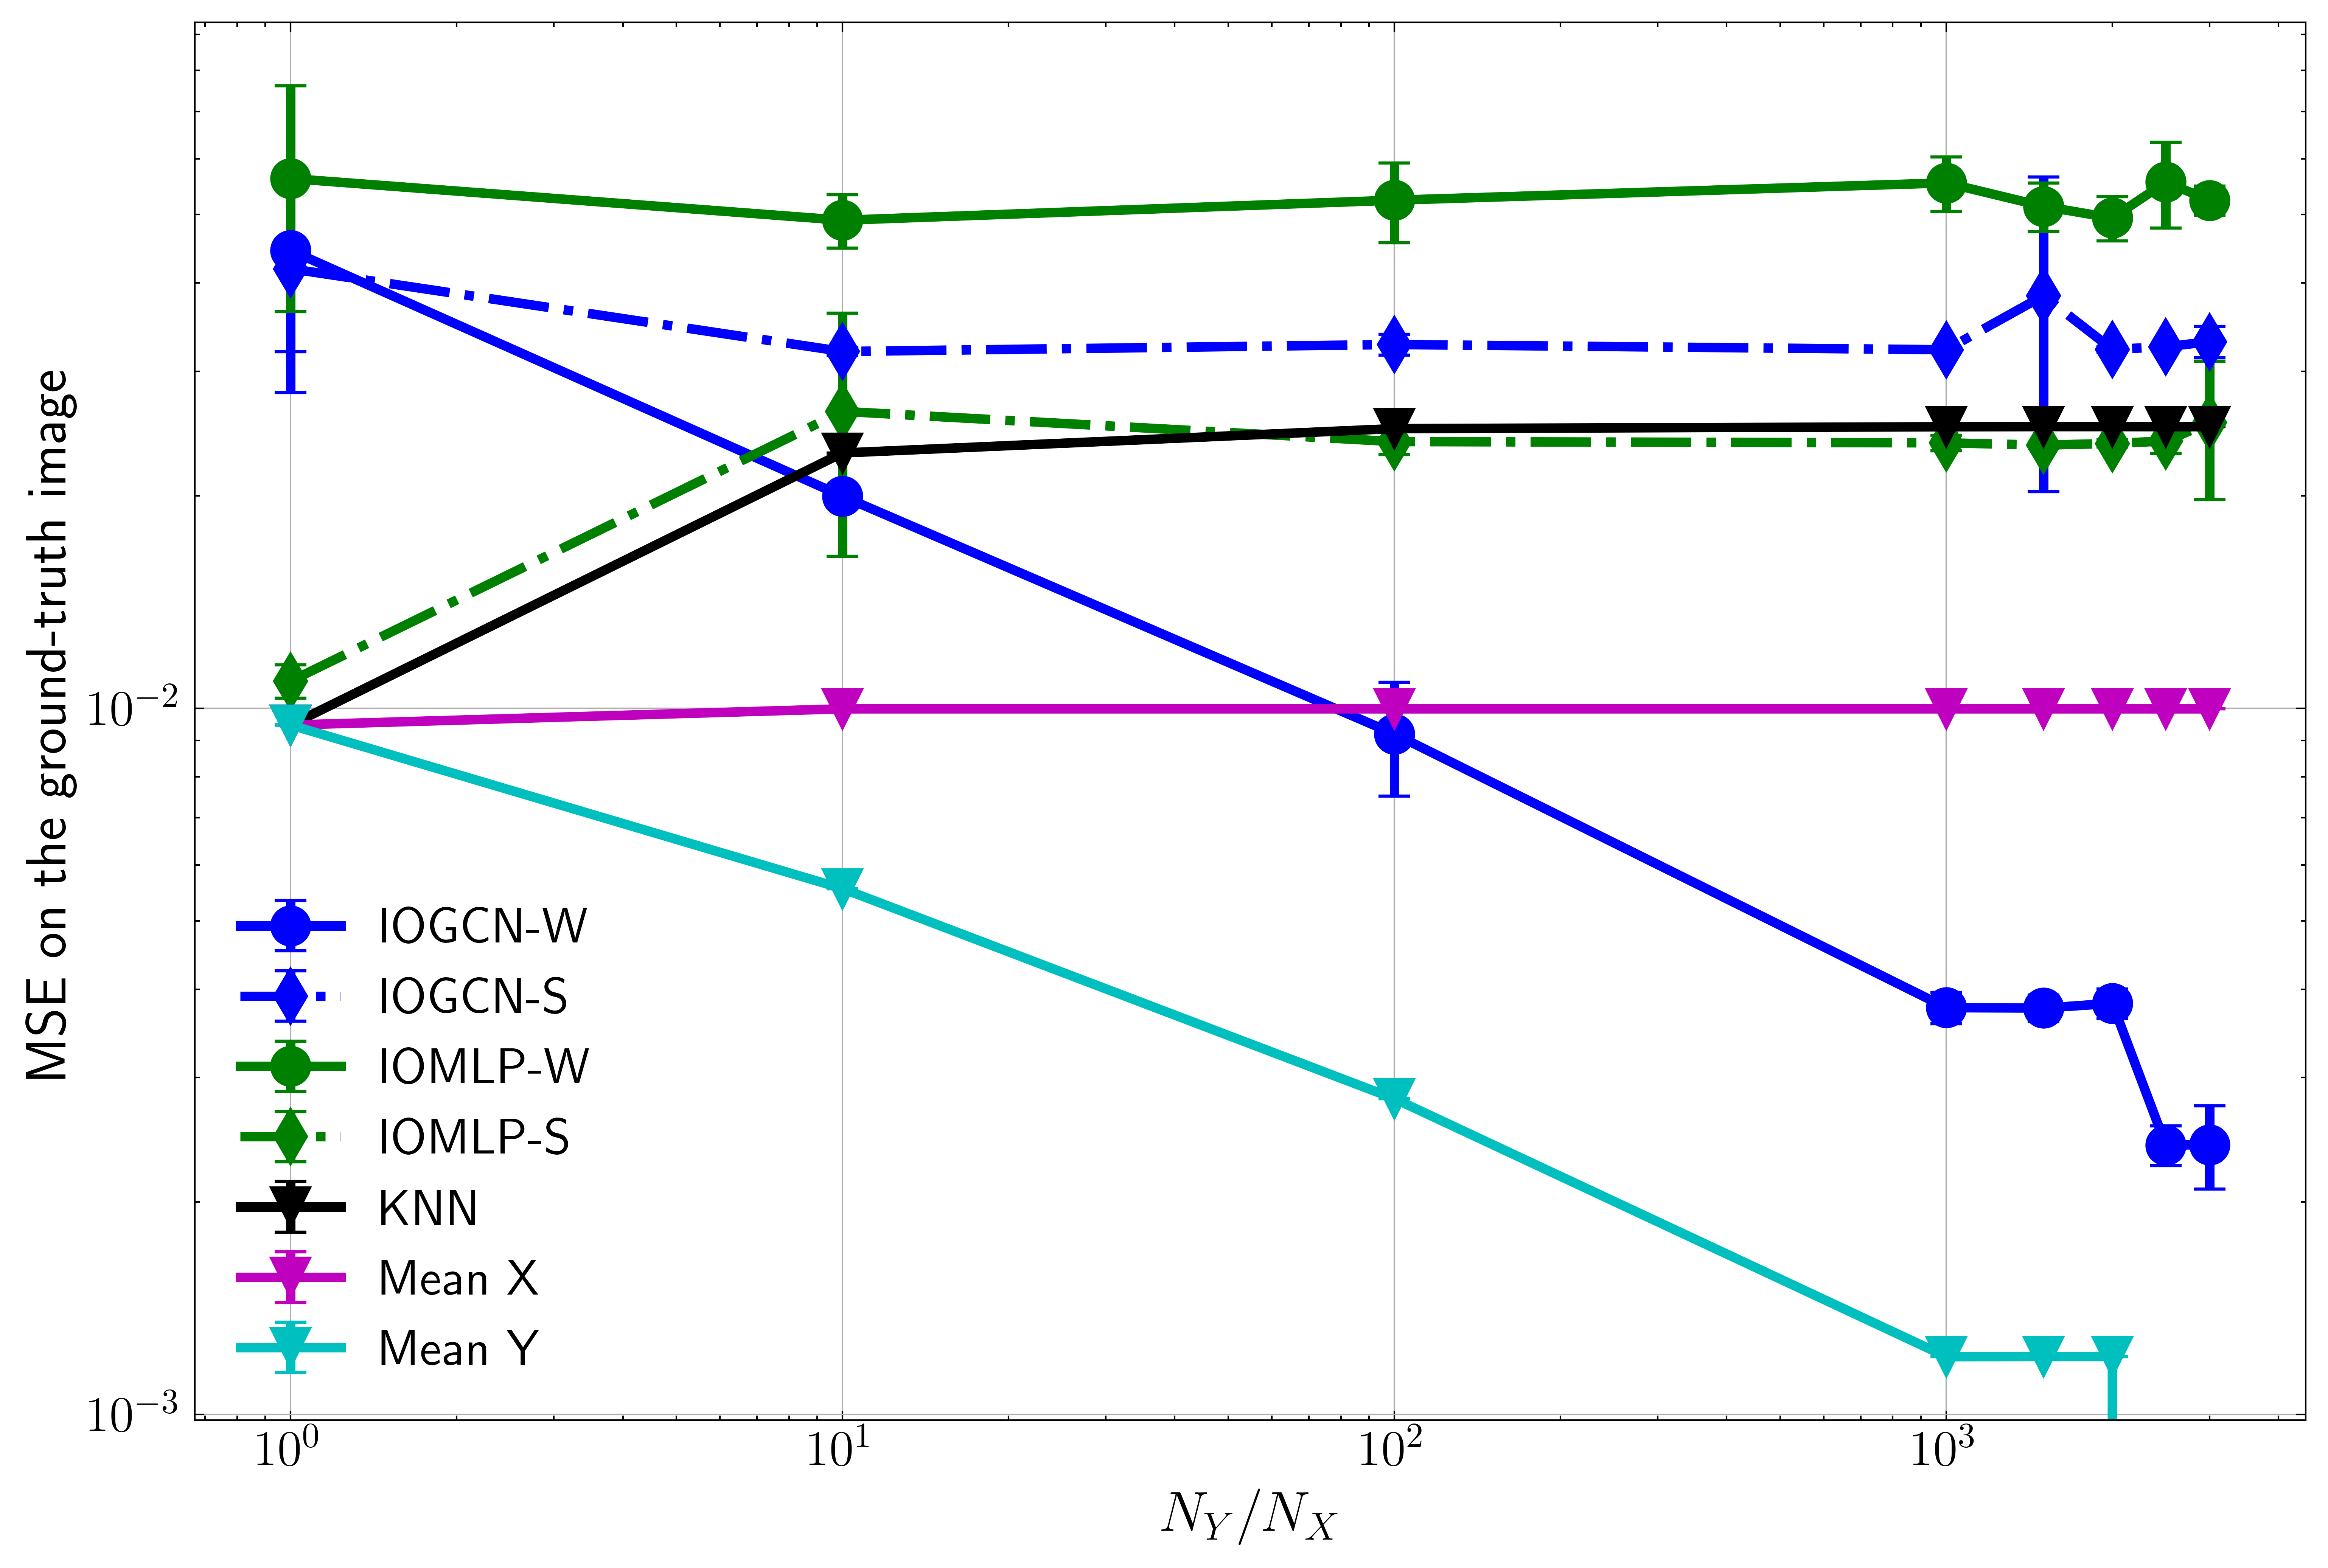

In [50]:
with plt.style.context(['science', 'ieee']):
    common_args = {"linewidth": 3, "markersize": 12, "capsize": 5}
    plt.figure(figsize=(12,8))
    ax = plt.axes()
    ax.set_xscale("log")
    ax.set_yscale("log")

    colors = {'IOGCN': 'b', 'IOGAT': 'r', 'IOMLP': 'g'}
    methods = {'linear': 'o-', 'transpose': 's--', 'selection': 'd-.'}

    for i, exp in enumerate(EXPS):
        if exp['method'] == 'transpose':
            continue
        plt.errorbar(NyNxratios, err_img.mean(2)[:,i], yerr=err_img.std(2)[:,i],
                     fmt=methods[exp['method']], color=colors[exp['model_name']], label=exp['legend'],
                     **common_args)

    plt.errorbar(NyNxratios, err_img.mean(2)[:,-3], yerr=err_img.std(2)[:,-3],
                 fmt='v-', color='k', label="KNN", **common_args)
    plt.errorbar(NyNxratios, err_img.mean(2)[:,-2], yerr=err_img.std(2)[:,-2],
                 fmt='v-', color='m', label="Mean X", **common_args)
    plt.errorbar(NyNxratios, err_img.mean(2)[:,-1], yerr=err_img.std(2)[:,-1],
                 fmt='v-', color='c', label="Mean Y", **common_args)

    plt.xlabel("$N_Y / N_X$", fontsize=18)
    plt.ylabel("MSE on the ground-truth image", fontsize=18)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.grid()

    plt.legend(fontsize=16)

    plt.savefig('image_interpolation.pdf')